# Diabetes Outcome Analysis

**Noah Burra**

**Date**: 3/29/2025

**Load the dataset and gather summary statistics**

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import accuracy_score

df = pd.read_csv("diabetes.csv")
df.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


The data contains many components such as BP, Insulin, BMI, Age etc. These are very valuable for comparisons as well as building a model in the future for predictions. There are 0.0000... in the dataset which cannot correlate to certain components like Glucose or Insulin, therefore they are NULL.

**Demonstrate univariate and/or pairwise patterns in the data**


Text(0.5, 1.02, 'Pairwise Plot - Blood Pressure and BMI')

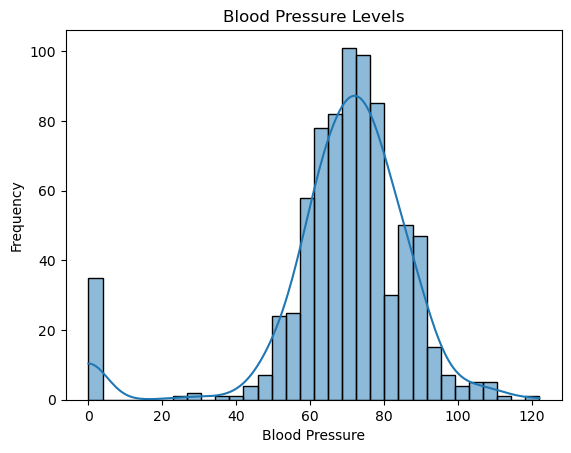

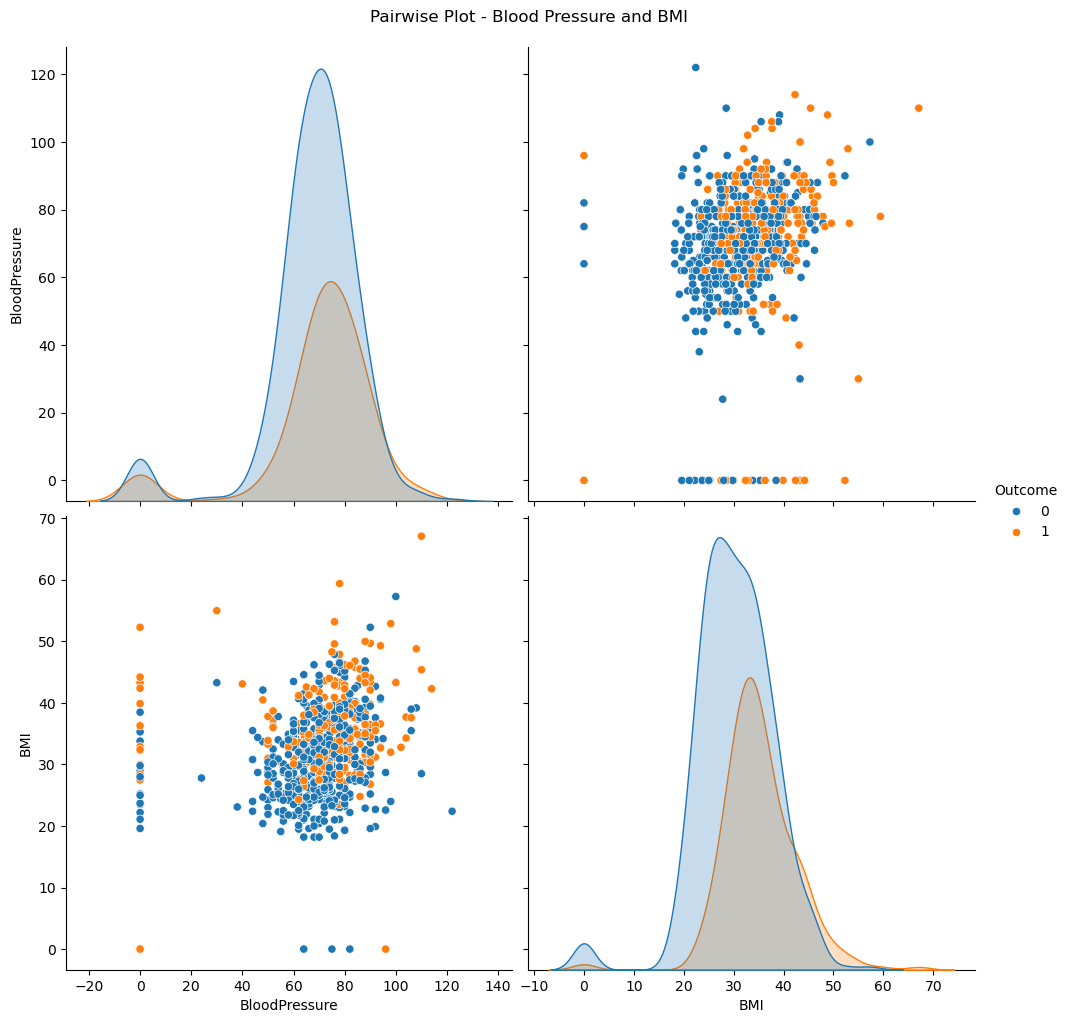

In [4]:
sns.histplot(df["BloodPressure"], kde=True)
plt.title("Blood Pressure Levels")
plt.xlabel("Blood Pressure")
plt.ylabel("Frequency")

sns.pairplot(df, vars=["BloodPressure", "BMI"], hue="Outcome", height=5)
plt.suptitle("Pairwise Plot - Blood Pressure and BMI", y=1.02)

The histogram showing the distribution of blood pressure levels in the dataset show that there are a large amount of values between 60 and 80. This is the most common values of blood pressure in the data set and correlates to the standard of blood pressure levels which is 120/80. There are some values of 0 in the blood pressure category that are due to NULL values, this may skew the histogram.

The pairwise graphs show the relationship between blood pressure and bmi. This shows that people with higher BMI will tend to have higher blood pressures. However, as it is seen in the graphs, lower BMI individuals can still have stable blood pressures.


**Evaluate and handle the data for missing or invalid values**


In [5]:
col_with_zero = ["Glucose", "BloodPressure", "SkinThickness", "Insulin", "BMI"]
not_usable = (df[col_with_zero] == 0).sum()
print(not_usable)

df[col_with_zero] = df[col_with_zero].replace(0, np.nan)
impute = SimpleImputer(strategy="median")
df[col_with_zero] = impute.fit_transform(df[col_with_zero])

Glucose            5
BloodPressure     35
SkinThickness    227
Insulin          374
BMI               11
dtype: int64


This dataset has many missing values. More specifically lots of zeros in the skinthickness category. Completely removing these categories may affect the data, therefore the best action is to present this data through the median values.

**Split the data into train/test sets, Encode categorical data and normalize numeric data**


In [6]:
X = df.drop("Outcome", axis=1)
y = df["Outcome"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y)

scale = StandardScaler()
X_train = scale.fit_transform(X_train)
X_test = scale.transform(X_test)

**Build the model to predict the target variable, Use GridSearchCV to tune hyperparameters, Perform cross validation**

In [16]:
parameters = {
    "C": [0.01, 0.1, 1, 10, 100, 1000],
    "gamma": [10, 1, 0.1, 0.01, 0.001, 0.0001]
}

model = SVC()

model = GridSearchCV(model, parameters, cv=5, return_train_score=True)
model.fit(X_train, y_train)

print("Parameters:", model.best_params_)
print("Score:", model.best_score_)

Parameters: {'C': 100, 'gamma': 0.001}
Score: 0.7857390100380754


**Evaluate the scores from GridSearchCV to diagnose any bias-variance problems**

In [8]:
table = pd.DataFrame(model.cv_results_)

table = table.sort_values("mean_test_score", ascending=False)

table[["mean_train_score", "std_train_score", "mean_test_score", "std_test_score"]].head()

,mean_train_score,std_train_score,mean_test_score,std_test_score
28,0.788637,0.006270,0.785739,0.031903
35,0.788637,0.008343,0.778280,0.037695
34,0.800272,0.007321,0.776411,0.036602
29,0.789103,0.006615,0.772776,0.024356
22,0.789568,0.006464,0.770907,0.022942


Between the train and test scores, there is very little difference or variance. What this means is that the model is good at predicting if an individual has diabetes. There is only decimal differences. Not only this but a low std_train_score of 0.006720 shows that there is consistency in the model's predictions. There is a mean accuracy above 78% which is good but could be better.

**Perform on KNN and DecisionTree**

In [17]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, accuracy_score

# scale
scale = StandardScaler()
X_train_scale = scale.fit_transform(X_train)
X_test_scale = scale.transform(X_test)

# knn
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train_scale, y_train)
knn_y = knn.predict(X_test_scale)

print(classification_report(y_test, knn_y))
print("KNN Accuracy:", accuracy_score(y_test, knn_y))

# tree
tree = DecisionTreeClassifier(random_state=42)
tree.fit(X_train, y_train)
tree_y = tree.predict(X_test)

print(classification_report(y_test, tree_y))
print("Tree Accuracy:", accuracy_score(y_test, tree_y))

              precision    recall  f1-score   support

           0       0.79      0.83      0.81       150
           1       0.65      0.58      0.61        81

    accuracy                           0.74       231
   macro avg       0.72      0.71      0.71       231
weighted avg       0.74      0.74      0.74       231

KNN Accuracy: 0.7445887445887446
              precision    recall  f1-score   support

           0       0.76      0.79      0.77       150
           1       0.57      0.53      0.55        81

    accuracy                           0.70       231
   macro avg       0.66      0.66      0.66       231
weighted avg       0.69      0.70      0.69       231

Tree Accuracy: 0.696969696969697


When the tree model, svm, and knn model are compared it is evident that the svm model is the best at predicting diabetes as most mean accuracies is over 78%, not only that but the std across train and test is low which indicates consistency across the model. Second to this is the knn model with an accuracy score of 0.744 or 74%. The decision tree is the lowest with 69%. The decision tree had significantly lower f1 scores than knn or svm as it had 0.77 for class 0 and 0.55 for class 1. Therefore the best overall model is the svm model. In the medical industry I would advocate for the svm model, although the model itself needs a higher score than 78% mean accuracy. However, it is efficient in predicting diabetes and would be beneficial for health professionals.